<a href="https://colab.research.google.com/github/devinandana01/TREC/blob/main/ASSIGNMENT_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install transformers datasets tensorflow

In [ ]:
from datasets import load_dataset

# Load the Emotion dataset
dataset = load_dataset('trec')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Inspect the dataset features
print("\nFeatures in the dataset:")
print(dataset['train'].features)


Features in the dataset:
{'text': Value(dtype='string', id=None), 'coarse_label': ClassLabel(names=['ABBR', 'ENTY', 'DESC', 'HUM', 'LOC', 'NUM'], id=None), 'fine_label': ClassLabel(names=['ABBR:abb', 'ABBR:exp', 'ENTY:animal', 'ENTY:body', 'ENTY:color', 'ENTY:cremat', 'ENTY:currency', 'ENTY:dismed', 'ENTY:event', 'ENTY:food', 'ENTY:instru', 'ENTY:lang', 'ENTY:letter', 'ENTY:other', 'ENTY:plant', 'ENTY:product', 'ENTY:religion', 'ENTY:sport', 'ENTY:substance', 'ENTY:symbol', 'ENTY:techmeth', 'ENTY:termeq', 'ENTY:veh', 'ENTY:word', 'DESC:def', 'DESC:desc', 'DESC:manner', 'DESC:reason', 'HUM:gr', 'HUM:ind', 'HUM:title', 'HUM:desc', 'LOC:city', 'LOC:country', 'LOC:mount', 'LOC:other', 'LOC:state', 'NUM:code', 'NUM:count', 'NUM:date', 'NUM:dist', 'NUM:money', 'NUM:ord', 'NUM:other', 'NUM:period', 'NUM:perc', 'NUM:speed', 'NUM:temp', 'NUM:volsize', 'NUM:weight'], id=None)}


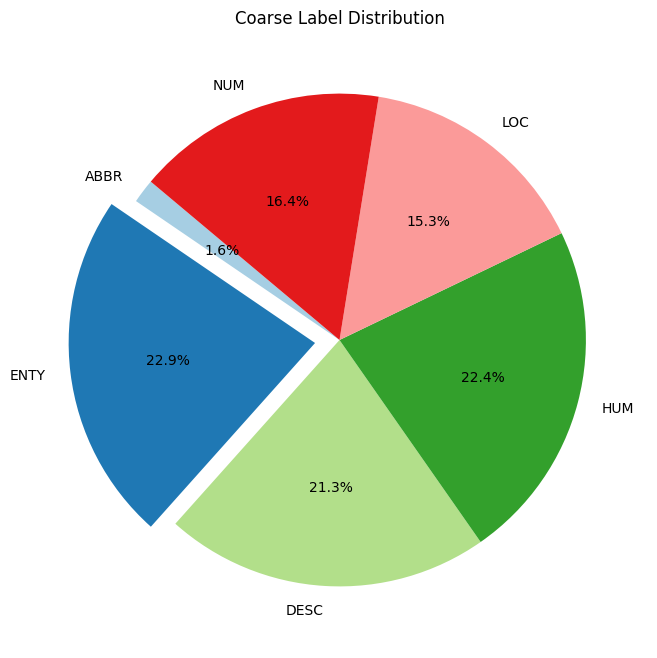

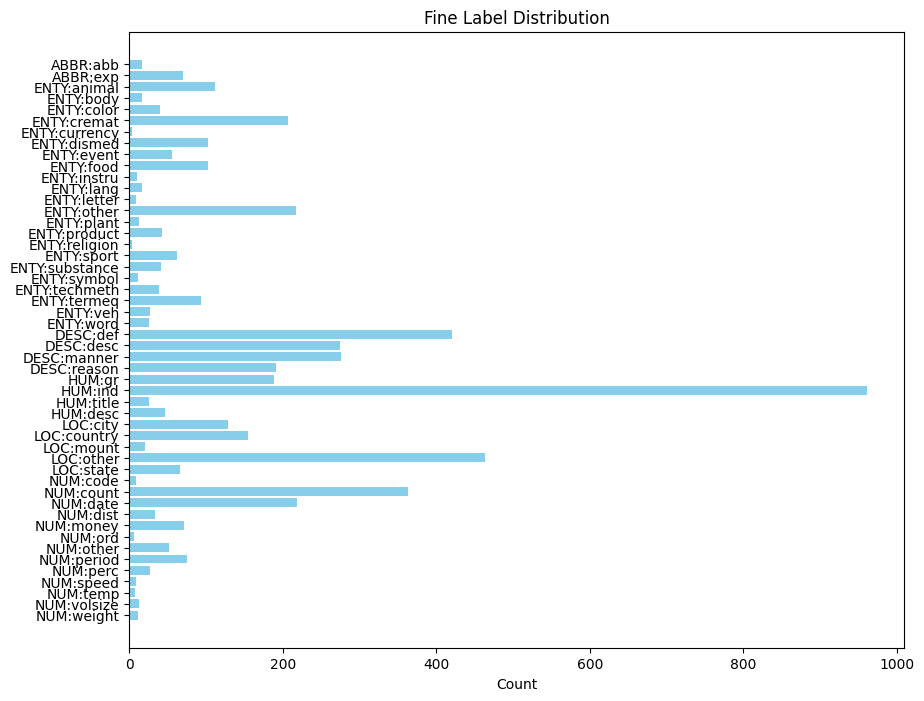

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot a pie chart with explosion for better visualization
def plot_pie_chart_with_explode(label_counts, label_names, title):
    plt.figure(figsize=(8, 8))
    explode = [0.1 if count == max(label_counts) else 0 for count in label_counts]  # Explode the largest slice
    plt.pie(label_counts, labels=label_names, autopct='%1.1f%%', startangle=140, explode=explode, colors=plt.cm.Paired(np.arange(len(label_names))))
    plt.title(title)
    plt.show()

# Plot a bar chart for better visualization of fine labels
def plot_bar_chart(label_counts, label_names, title):
    plt.figure(figsize=(10, 8))
    y_pos = np.arange(len(label_names))
    plt.barh(y_pos, label_counts, color='skyblue')
    plt.yticks(y_pos, label_names)
    plt.xlabel('Count')
    plt.title(title)
    plt.gca().invert_yaxis()  # Invert y-axis to have the largest label on top
    plt.show()

# Get label names and counts for coarse labels
coarse_labels = dataset['train'].features['coarse_label'].names
coarse_label_counts = np.bincount(dataset['train']['coarse_label'])

# Plot pie chart with explode for coarse labels
plot_pie_chart_with_explode(coarse_label_counts, coarse_labels, "Coarse Label Distribution")

# Get label names and counts for fine labels
fine_labels = dataset['train'].features['fine_label'].names
fine_label_counts = np.bincount(dataset['train']['fine_label'])

# Plot horizontal bar chart for fine labels
plot_bar_chart(fine_label_counts, fine_labels, "Fine Label Distribution")

In [ ]:

from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# Tokenize the texts
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

In [ ]:
# Apply the tokenizer to the dataset
encoded_dataset = dataset.map(tokenize_function, batched=True)

In [ ]:
# Set format for TensorFlow
encoded_dataset.set_format(type='tensorflow', columns=['input_ids', 'attention_mask', 'fine_label'])

In [ ]:
import tensorflow as tf

# Convert to TensorFlow dataset
def to_tf_dataset(dataset, batch_size=16):
    features = {x: tf.convert_to_tensor(dataset[x]) for x in ['input_ids', 'attention_mask']}
    labels = tf.convert_to_tensor(dataset['coarse_label'])
    return tf.data.Dataset.from_tensor_slices((features, labels)).batch(batch_size)

    # Use a subset of the dataset for quicker experiments
train_dataset = to_tf_dataset(encoded_dataset['train'].select(range(2000)))
test_dataset = to_tf_dataset(encoded_dataset['test'].select(range(500)))

In [ ]:
from transformers import TFBertForSequenceClassification

# Load BERT model with a classification head
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)  # Number of emotion categories


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:

# Train the model
model.fit(train_dataset, validation_data=test_dataset, epochs=3)


# Evaluate the model
eval_results = model.evaluate(test_dataset)
print(f"Evaluation results: {eval_results}")


Epoch 1/3
125/125 [==============================] - 2949s 23s/step - loss: 0.9045 - accuracy: 0.6750 - val_loss: 0.1866 - val_accuracy: 0.9520
Epoch 2/3
125/125 [==============================] - 3121s 25s/step - loss: 0.2155 - accuracy: 0.9370 - val_loss: 0.2555 - val_accuracy: 0.9280
Epoch 3/3
32/32 [==============================] - 230s 7s/step - loss: 0.1410 - accuracy: 0.9660
Evaluation results: [0.14099502563476562, 0.9660000205039978]


In [ ]:
import tensorflow as tf
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to preprocess the input text
def preprocess_text(text):
    # Tokenize the input text
    encoding = tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors='tf')
    return encoding['input_ids'], encoding['attention_mask']

# Function to make predictions
def predict_text(text, model):
    input_ids, attention_mask = preprocess_text(text)

    # Make predictions
    predictions = model(input_ids, attention_mask=attention_mask)

    # Get the predicted class
    predicted_class = tf.argmax(predictions.logits, axis=1).numpy()[0]
    return predicted_class

# Example usage
example_text = "What is the capital of France?"

# Make a prediction
predicted_class = predict_text(example_text, model)
print(f"Predicted class: {predicted_class}")


Predicted class: 4


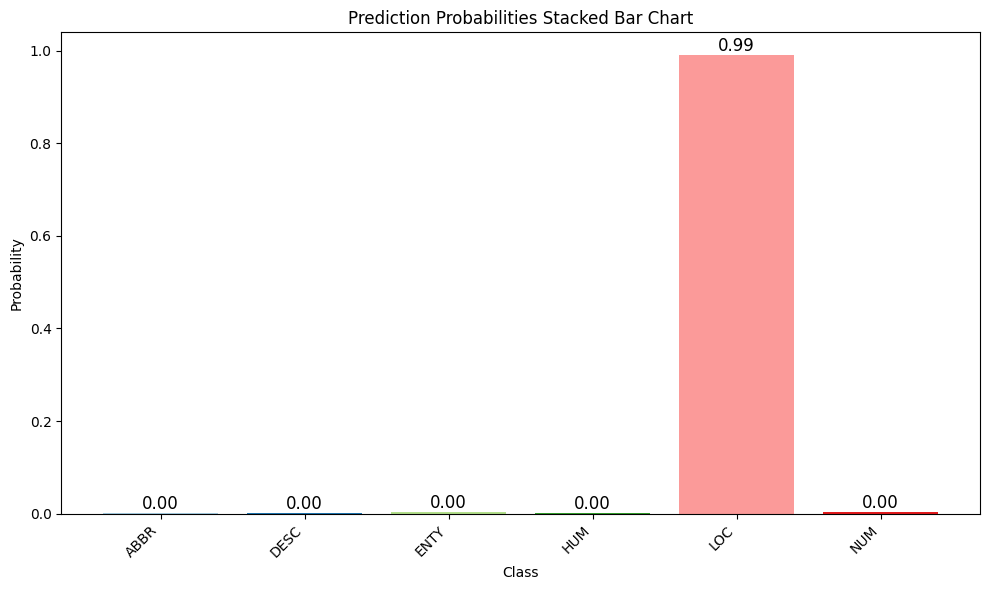

Predicted class: LOC


In [ ]:
# Function to make predictions and visualize them with a stacked bar chart
def predict_and_visualize_stacked_bar(text, model, label_names):
    input_ids, attention_mask = preprocess_text(text)

    # Make predictions
    predictions = model(input_ids, attention_mask=attention_mask)

    # Get the predicted probabilities
    predicted_probabilities = tf.nn.softmax(predictions.logits, axis=1).numpy()[0]

    # Plot the stacked bar chart
    plt.figure(figsize=(10, 6))

    # Stacked bar chart
    bars = plt.bar(label_names, predicted_probabilities, color=plt.cm.Paired(range(len(label_names))))
    plt.xlabel('Class')
    plt.ylabel('Probability')
    plt.title('Prediction Probabilities Stacked Bar Chart')

    # Add value labels on top of the bars
    for bar, prob in zip(bars, predicted_probabilities):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{prob:.2f}',
                 ha='center', va='bottom', fontsize=12, color='black')

    plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
    plt.tight_layout()
    plt.show()

    # Get the predicted class
    predicted_class = np.argmax(predicted_probabilities)

    return predicted_class

# Example usage
example_text = "What is the capital of France?"

# Assuming you have the label names for the classes (coarse labels in TREC dataset)
label_names = ['ABBR', 'DESC', 'ENTY', 'HUM', 'LOC', 'NUM']

# Make a prediction and visualize it with a stacked bar chart
predicted_class = predict_and_visualize_stacked_bar(example_text, model, label_names)
print(f"Predicted class: {label_names[predicted_class]}")